<a href="https://colab.research.google.com/github/kristina-skoptsova/diplom/blob/main/model_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
file = '/content/dataset_muiv.csv'
df = pd.read_csv(file)
df = pd.DataFrame(df)
df

,Направление,Год поступления,Количество поступивших,Сумма баллов,Сумма баллов за ВИ,Кол-во баллов за ИД,Возраст,Регион рождения,Уровень безработицы,Доля женщин,Доля преимущественного права,Доля наличия договора
0,1,1908,11,180.909091,76.090909,83.454545,25.636364,76.090909,33.727273,0.454545,0.181818,0.000000
1,1,1909,11,181.636364,69.272727,82.727273,24.545455,69.272727,29.909091,0.214286,0.000000,0.214286
2,1,1910,11,173.636364,63.181818,83.181818,23.820205,63.181818,27.000000,0.210526,0.105263,0.052632
3,1,1911,11,184.181818,72.454545,82.909091,26.913137,72.454545,32.636364,0.312500,0.125000,0.000000
4,1,1912,11,193.454545,69.545455,82.363636,26.636364,69.545455,29.909091,0.113636,0.045455,0.068182
...,...,...,...,...,...,...,...,...,...,...,...,...
5962,51,2020,19,183.210526,61.842105,80.105263,26.899422,61.842105,17.052632,0.333333,0.041667,0.291667
5963,51,2021,20,192.150000,70.600000,75.750000,26.301113,70.600000,17.850000,0.225806,0.032258,0.096774
5964,51,2022,20,181.950000,62.550000,77.050000,26.702225,62.550000,16.200000,0.916667,0.083333,0.166667
5965,51,2023,20,179.050000,69.900000,80.500000,24.903338,69.900000,18.800000,0.666667,0.000000,0.333333


In [16]:
columns_to_drop = ["Уровень безработицы", "Регион рождения", "Доля наличия договора"]
df = df.drop(columns=columns_to_drop)

from sklearn.preprocessing import RobustScaler

# Колонки, которые не нужно масштабировать
exclude_columns = ['Направление', 'Год поступления', 'Количество поступивших']
# Колонки для масштабирования
columns_to_scale = [col for col in df.columns if col not in exclude_columns]

# Применение RobustScaler
scaler = RobustScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

X = df.drop(columns=['Количество поступивших'])
y = df['Количество поступивших']

In [17]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

# Функция для создания последовательностей данных
def create_sequences(data, window_size):
    inputs, outputs, groups = [], [], []
    for direction in data['Направление'].unique():
        dir_data = data[data['Направление'] == direction].sort_values('Год поступления')
        for i in range(len(dir_data) - window_size):
            seq = dir_data.iloc[i:i+window_size].drop(['Направление', 'Год поступления', 'Количество поступивших'], axis=1).values
            target = dir_data.iloc[i+window_size]['Количество поступивших']
            direction_label = dir_data.iloc[i+window_size]['Направление']  # Направление для следующего шага
            inputs.append(seq)
            outputs.append(target)
            groups.append(direction_label)
    return np.array(inputs), np.array(outputs), np.array(groups)

# Создание последовательностей
YEARS_SIZE = 5
X, y, direction_labels = create_sequences(df, YEARS_SIZE)

# Нормализация целевой переменной
y_scaler = RobustScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test, direction_train, direction_test = train_test_split(
    X, y, direction_labels, test_size=0.2, random_state=42)

# Рассчитываются веса только для тренировочной выборки
unique_directions, direction_counts_train = np.unique(direction_train, return_counts=True)
direction_weights_train = {direction: 1.0 / count for direction, count in zip(unique_directions, direction_counts_train)}

# Применение весов к данным
sample_weights = df['Направление'].map(direction_weights_train).values

# Ограничение веса для тренировочной выборки
train_sample_weights = sample_weights[:len(y_train)]

# Архитектура модели
model_lstm = Sequential([
    Input(shape=(YEARS_SIZE, X.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.1),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1)
])

# Компиляция модели
model_lstm.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Ранняя остановка при переобучении
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True  # Восстановление весов модели с лучшим результатом
)

# Обучение модели
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    sample_weight=train_sample_weights,  # Использование веса
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Оценка модели на тестовой выборке
test_loss, test_mae = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0059 - mae: 0.5255 - val_loss: 0.0035 - val_mae: 0.3152
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mae: 0.3146 - val_loss: 0.0031 - val_mae: 0.2832
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - mae: 0.2832 - val_loss: 0.0029 - val_mae: 0.2623
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mae: 0.2727 - val_loss: 0.0028 - val_mae: 0.2524
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - mae: 0.2656 - val_loss: 0.0027 - val_mae: 0.2441
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.2559 - val_loss: 0.0026 - val_mae: 0.2401
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.2439 - val_loss: 0.0026 - val_mae: 0.2385
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.2421 - val_loss: 0.0026 - val_mae: 0.2363
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.00

In [5]:
# Сохранение модели
model_lstm.save('lstm_model.keras')

In [18]:
# Предсказание модели
predictions = model_lstm.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)  # Обратное преобразование
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Создание DataFrame для анализа
test_df = pd.DataFrame({
    'Направление': direction_test,
    'Фактическое': y_test_original.flatten(),
    'Предсказанное': predictions.flatten()
})

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


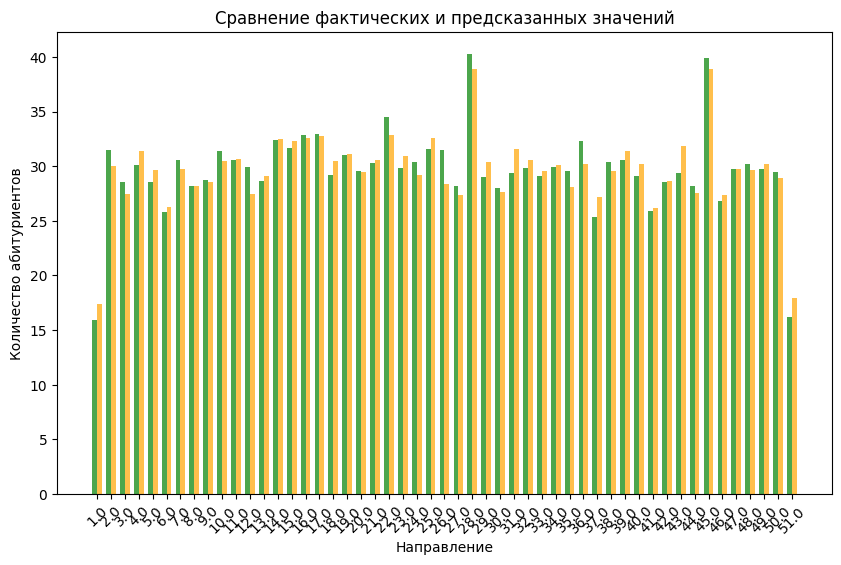

In [19]:
# Группировка данных
mean_values = test_df.groupby('Направление').agg(
    Фактическое_среднее=('Фактическое', 'mean'),
    Предсказанное_среднее=('Предсказанное', 'mean')
).reset_index()

# Построение графика
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(mean_values))

plt.bar(index, mean_values['Фактическое_среднее'], bar_width, label='Фактическое', alpha=0.7, color='green')
plt.bar(index + bar_width, mean_values['Предсказанное_среднее'], bar_width, label='Предсказанное', alpha=0.7, color='orange')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Направление')
plt.ylabel('Количество абитуриентов')
plt.xticks(index + bar_width / 2, mean_values['Направление'], rotation=45)
plt.show()

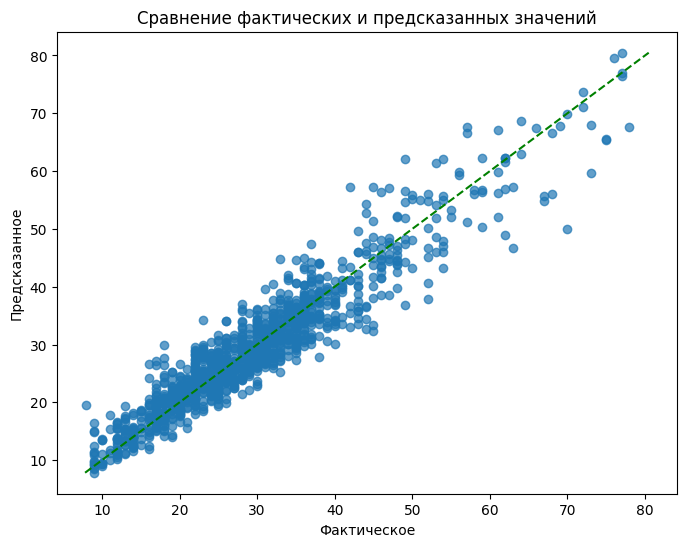

In [20]:
# Построение графика
plt.figure(figsize=(8, 6))
plt.scatter(test_df['Фактическое'], test_df['Предсказанное'], alpha=0.7)

# Линия идеального соответствия
lims = [np.min([test_df['Фактическое'], test_df['Предсказанное']]),
        np.max([test_df['Фактическое'], test_df['Предсказанное']])]
plt.plot(lims, lims, color='green', linestyle='--')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Фактическое')
plt.ylabel('Предсказанное')
plt.show()

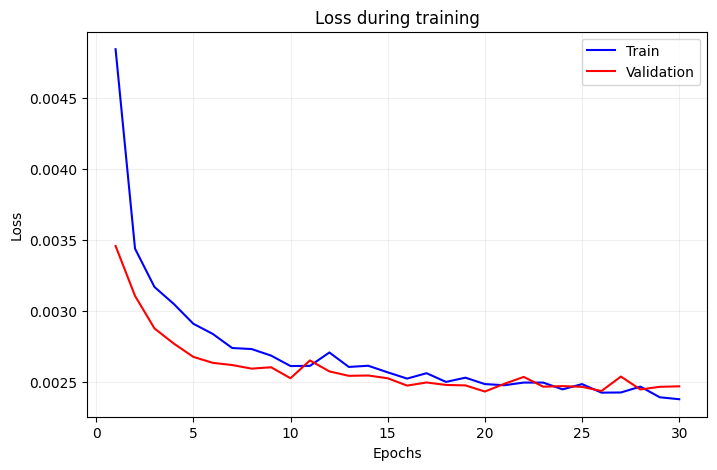

In [21]:
def show_training(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b', label='Train')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

# Вызов функции после обучения модели
show_training(history_lstm)

In [22]:
!pip install streamlit
!npm install localtunnel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.2 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
added 22 packages in 3s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸

In [26]:
%%writefile app.py
from keras.models import load_model
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import os
import tempfile

# Инициализация сессии для хранения состояния
if 'model' not in st.session_state:
    st.session_state.model = None
if 'data' not in st.session_state:
    st.session_state.data = None
if 'scaler' not in st.session_state:
    st.session_state.scaler = RobustScaler()

st.title("Прогнозирование абитуриентов")

# Основной интерфейс
st.title("Система прогнозирования набора абитуриентов по направлению подготовки высшего образования")
# Создание вкладок
tab1, tab2, tab3 = st.tabs(["Загрузка данных", "Обучение модели", "Тестирование модели"])

# Вкладка 1: Загрузка данных
with tab1:
    st.header("Загрузка данных")
    st.write("Загрузите файл CSV с данными для анализа.")
    uploaded_file = st.file_uploader("Выберите файл CSV", type=["csv"])
    if uploaded_file is not None:
        data = pd.read_csv(uploaded_file)
        st.write("Первые 5 строк загруженного файла:")
        st.dataframe(data.head())

        # Проверка наличия необходимых столбцов
        required_columns = {"Направление", "Год поступления", "Количество поступивших"}
        if not required_columns.issubset(data.columns):
            st.error(f"Ошибка: В данных отсутствуют необходимые столбцы: {required_columns}")
        else:
            # Удаление колонок
            columns_to_drop = ["Уровень безработицы", "Регион рождения", "Доля наличия договора"]
            data = data.drop(columns=columns_to_drop)
            # Колонки, которые не нужно масштабировать
            exclude_columns = ['Направление', 'Год поступления', 'Количество поступивших']
            # Колонки для масштабирования
            columns_to_scale = [col for col in data.columns if col not in exclude_columns]
            # Применение RobustScaler
            scaler = RobustScaler()
            data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
            # Сохранение данных
            st.session_state.data = data

# Вкладка 2: Обучение модели
with tab2:
    st.header("Обучение модели")
    if st.session_state.data is None:
        st.warning("Сначала загрузите данные на вкладке 'Загрузка данных'")
    else:
        if st.button("Начать обучение"):
            with st.spinner("Обучение модели..."):
                try:
                    import tensorflow as tf
                    from keras.models import Sequential
                    from keras.layers import Dense, Input, LSTM, Dropout
                    from sklearn.model_selection import train_test_split
                    from sklearn.preprocessing import RobustScaler
                    from keras.callbacks import EarlyStopping

                    X = st.session_state.data.drop(columns=['Количество поступивших'])
                    y = st.session_state.data['Количество поступивших']
                    # Функция для создания последовательностей данных
                    def create_sequences(data, window_size):
                        inputs, outputs, groups = [], [], []
                        for direction in data['Направление'].unique():
                            dir_data = data[data['Направление'] == direction].sort_values('Год поступления')
                            for i in range(len(dir_data) - window_size):
                                seq = dir_data.iloc[i:i+window_size].drop(['Направление', 'Год поступления', 'Количество поступивших'], axis=1).values
                                target = dir_data.iloc[i+window_size]['Количество поступивших']
                                direction_label = dir_data.iloc[i+window_size]['Направление']  # Направление для следующего шага
                                inputs.append(seq)
                                outputs.append(target)
                                groups.append(direction_label)
                        return np.array(inputs), np.array(outputs), np.array(groups)

                    # Создание последовательностей
                    YEARS_SIZE = 5
                    X, y, direction_labels = create_sequences(st.session_state.data, YEARS_SIZE)

                    # Нормализация целевой переменной
                    y_scaler = RobustScaler()
                    y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

                    # Разделение данных на тренировочную и тестовую выборки
                    X_train, X_test, y_train, y_test, direction_train, direction_test = train_test_split(
                        X, y, direction_labels, test_size=0.2, random_state=42)

                    # Сохрание x_test и y_test
                    st.session_state.X_test = X_test
                    st.session_state.y_test = y_test

                    # Рассчитываются веса только для тренировочной выборки
                    unique_directions, direction_counts_train = np.unique(direction_train, return_counts=True)
                    direction_weights_train = {direction: 1.0 / count for direction, count in zip(unique_directions, direction_counts_train)}

                    # Применение весов к данным
                    sample_weights = st.session_state.data['Направление'].map(direction_weights_train).values

                    # Ограничение веса для тренировочной выборки
                    train_sample_weights = sample_weights[:len(y_train)]

                    # Архитектура модели
                    model_lstm = Sequential([
                        Input(shape=(YEARS_SIZE, X.shape[2])),
                        LSTM(128, return_sequences=True),
                        Dropout(0.1),
                        LSTM(64),
                        Dense(32, activation='relu'),
                        Dense(1)
                    ])

                    # Компиляция модели
                    model_lstm.compile(optimizer='adam', loss='mae', metrics=['mae'])

                    # Ранняя остановка при переобучении
                    early_stopping = EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True  # Восстановление весов модели с лучшим результатом
                    )

                    # Обучение модели
                    history_lstm = model_lstm.fit(
                        X_train,
                        y_train,
                        sample_weight=train_sample_weights,  # Использование веса
                        epochs=100,
                        batch_size=64,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=1
                    )

                    # Сохранение модели
                    model_lstm.save('lstm_model.keras')
                    st.success('Модель успешно обучена и сохранена!')
                    st.session_state.model = model_lstm

                    # Сохранение scaler для предсказаний
                    st.session_state.scaler = y_scaler

                    # Визуализация обучения
                    st.line_chart(pd.DataFrame(history_lstm.history))

                    # Возможность скачивания файла
                    with open('lstm_model.keras', 'rb') as file:
                      st.download_button(
                          label='Скачать модель',
                          data=file,
                          file_name='lstm_model.keras',
                          mime='application/octet-stream'
                          )
                except Exception as e:
                  st.error(f"Ошибка при обучении модели: {e}")

# Вкладка 3: Тестирование модели
with tab3:
    st.header("Тестирование модели")
    # Загрузка модели
    st.subheader("Загрузка модели")
    uploaded_model = st.file_uploader("Выберите файл модели (.keras)", type=["keras"])
    if uploaded_model:
      with tempfile.NamedTemporaryFile(delete=False, suffix=".keras") as tmp_file:
        tmp_file.write(uploaded_model.getvalue())
        st.session_state.model = load_model(tmp_file.name)
      st.success("Модель успешно загружена!")

    if st.session_state.model is None:
        st.warning("Сначала загрузите или обучите модель")
    else:
        # Подраздел: Оценка модели
        st.subheader("Оценка модели")
        if st.button("Оценить модель"):
            try:
                # Извлечение тестовых данных
                X_test = st.session_state.X_test
                y_test = st.session_state.y_test

                # Предсказания на тестовых данных
                predictions = st.session_state.model.predict(X_test)
                predictions = st.session_state.scaler.inverse_transform(predictions)
                y_test_original = st.session_state.scaler.inverse_transform(y_test.reshape(-1, 1))

                # Оценка качества модели
                from sklearn.metrics import mean_absolute_error, r2_score
                mae = mean_absolute_error(y_test_original, predictions)
                r2 = r2_score(y_test_original, predictions)
                st.write(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
                st.write(f"Коэффициент детерминации (R²): {r2:.2f}")

                # Отображение результатов
                results = pd.DataFrame({
                    "Реальные значения": y_test_original.flatten(),
                    "Предсказанные значения": predictions.flatten()
                })
                st.write("Результаты предсказания на тестовых данных:")
                st.dataframe(results)

            except Exception as e:
                st.error(f"Ошибка при оценке модели: {e}")
        # Подраздел: Прогнозирование
        st.subheader("Прогнозирование")
        all_directions = st.session_state.data['Направление'].unique().tolist()
        forecast_option = st.selectbox("Выберите направления для прогнозирования:", ["Все"] + all_directions)
        selected_directions = all_directions if forecast_option == "Все" else [forecast_option]
        if st.button("Запустить прогнозирование"):
            try:
                # Функция для предсказания следующего года
                def predict_next_year(model, df, years_size, y_scaler):
                    predictions = []

                    for direction in df['Направление'].unique():
                        if selected_directions != "Все" and direction not in selected_directions:
                            continue

                        dir_data = df[df['Направление'] == direction].sort_values('Год поступления')

                        # Если данных недостаточно для создания последовательности, пропускаем направление
                        if len(dir_data) < years_size:
                            st.write(f"Недостаточно данных для направления {direction}. Требуется минимум {years_size} года.")
                            continue

                        # Создаем последовательность из последних years_size лет
                        last_sequence = dir_data.iloc[-years_size:].drop(['Направление', 'Год поступления', 'Количество поступивших'], axis=1).values
                        last_sequence = last_sequence.reshape(1, years_size, last_sequence.shape[1])

                        # Нормализуем последовательность
                        scaler = RobustScaler()
                        last_sequence = scaler.fit_transform(last_sequence.reshape(-1, last_sequence.shape[2])).reshape(last_sequence.shape)

                        # Предсказываем количество абитуриентов
                        predicted_value = model.predict(last_sequence)

                        # Преобразуем предсказание обратно в исходный масштаб
                        predicted_value = y_scaler.inverse_transform(predicted_value)[0][0]

                        # Сохраняем результат
                        predictions.append({
                            'Направление': direction,
                            'Предсказанное количество абитуриентов': int(round(predicted_value))
                        })

                    # Создаем DataFrame с результатами
                    result_df = pd.DataFrame(predictions)
                    return result_df

                # Вызываем функцию предсказания
                YEARS_SIZE = 5
                predictions_df = predict_next_year(st.session_state.model, st.session_state.data, YEARS_SIZE, st.session_state.scaler)

                if predictions_df.empty:
                    st.error("Нет данных для выбранных направлений или недостаточно записей для прогнозирования.")
                else:
                    # Отображение результатов
                    st.write("Прогноз количества абитуриентов на следующий год:")
                    st.dataframe(predictions_df)

                    # Сохранение результатов прогноза
                    predictions_df.to_csv("results.csv", index=False)
                    st.success("Результаты прогноза успешно сохранены в файл results.csv!")
                    # Возможность скачивания файла
                    with open("results.csv", "rb") as file:
                      st.download_button(
                          label="Скачать результаты прогноза",
                          data=file,
                          file_name="results.csv",
                          mime="text/csv"
                          )
            except Exception as e:
                st.error(f"Ошибка при прогнозировании: {e}")

Overwriting app.py


In [24]:
import urllib
print("Пароль:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Пароль: 34.16.190.64


In [27]:
!streamlit run app.py --server.port 8501 &>/dev/null & npx localtunnel --port 8501

⠙your url is: https://empty-sheep-clean.loca.lt
^C
